In [7]:
from __future__ import division
import torch
import numpy as np
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
from utils import load_metr_la_rdata, get_normalized_adj, get_Laplace, calculate_random_walk_matrix,test_error,test_error_forecasting
import random
import pandas as pd
from basic_structure import D_GCN, C_GCN, K_GCN,IGNNK

import geopandas as gp
import matplotlib as mlt
from copy import deepcopy
import pickle as pkl

Define the hyper parameters

In [8]:
n_o_n_m = 150 #sampled space dimension

h = 24 #sampled time dimension

z = 100 #hidden dimension for graph convolution

K = 1 #If using diffusion convolution, the actual diffusion convolution step is K+1

n_m = 50 #number of mask node during training

N_u = 50 #target locations, N_u locations will be deleted from the training data

Max_episode = 750 #max training episode

learning_rate = 0.0001 #the learning_rate for Adam optimizer

E_maxvalue = 80 #the max value from experience

batch_size = 4 

Build the IGNNK model

Load data

In [9]:
A, X = load_metr_la_rdata()

split_line1 = int(X.shape[2] * 0.7)

training_set = X[:, 0, :split_line1].transpose()

test_set = X[:, 0, split_line1:].transpose()       # split the training and test period

full_dataset = X[:, 0, :].transpose()

rand = np.random.RandomState(0) # Fixed random output, just an example when seed = 0.
unknow_set = rand.choice(list(range(0,X.shape[0])),N_u,replace=False)
unknow_set = set(unknow_set)
full_set = set(range(0,207))        
know_set = full_set - unknow_set
training_set_s = training_set[:, list(know_set)]   # get the training data in the sample time period
A_s = A[:, list(know_set)][list(know_set), :]      # get the observed adjacent matrix from the full adjacent matrix,
                                                   # the adjacent matrix are based on pairwise distance, 
                                                   # so we need not to construct it for each batch, we just use index to find the dynamic adjacent matrix

Train the IGNNK model

In [21]:
X.shape

(207, 2, 34272)

In [7]:
training_set_s.shape

(23990, 157)

# Train kriging 

In [5]:
STmodel = IGNNK(h, z, K)  # The graph neural networks
criterion = nn.MSELoss()
optimizer = optim.Adam(STmodel.parameters(), lr=learning_rate)
RMSE_list = []
MAE_list = []
MAPE_list = []
for epoch in range(Max_episode):
    for i in range(training_set.shape[0]//(h * batch_size)):  #using time_length as reference to record test_error
        t_random = np.random.randint(0, high=(training_set_s.shape[0] - h), size=batch_size, dtype='l')
        know_mask = set(random.sample(range(0,training_set_s.shape[1]),n_o_n_m)) #sample n_o + n_m nodes
        feed_batch = []
        for j in range(batch_size):
            feed_batch.append(training_set_s[t_random[j]: t_random[j] + h, :][:, list(know_mask)]) #generate 8 time batches

        inputs = np.array(feed_batch)
        inputs_omask = np.ones(np.shape(inputs))
        inputs_omask[inputs == 0] = 0           # We found that there are irregular 0 values for METR-LA, so we treat those 0 values as missing data,
                                                # For other datasets, it is not necessary to mask 0 values

        missing_index = np.ones((inputs.shape))
        for j in range(batch_size):
            missing_mask = random.sample(range(0,n_o_n_m),n_m) #Masked locations
            missing_index[j, :, missing_mask] = 0
            
        Mf_inputs = inputs * inputs_omask * missing_index / E_maxvalue #normalize the value according to experience
        Mf_inputs = torch.from_numpy(Mf_inputs.astype('float32'))
        mask = torch.from_numpy(inputs_omask.astype('float32'))   #The reconstruction errors on irregular 0s are not used for training
        
        A_dynamic = A_s[list(know_mask), :][:, list(know_mask)]   #Obtain the dynamic adjacent matrix
        A_q = torch.from_numpy((calculate_random_walk_matrix(A_dynamic).T).astype('float32'))
        A_h = torch.from_numpy((calculate_random_walk_matrix(A_dynamic.T).T).astype('float32'))

        outputs = torch.from_numpy(inputs/E_maxvalue) #The label

        optimizer.zero_grad()
        X_res = STmodel(Mf_inputs, A_q, A_h)  #Obtain the reconstruction
        
        loss = criterion(X_res*mask, outputs*mask)
        loss.backward()
        optimizer.step()        #Errors backward
    
    MAE_t, RMSE_t, MAPE_t, metr_ignnk_res  = test_error(STmodel, unknow_set, test_set, A,E_maxvalue, True)
    RMSE_list.append(RMSE_t)
    MAE_list.append(MAE_t)
    MAPE_list.append(MAPE_t)
    if epoch%50 == 0:
        print(epoch, MAE_t, RMSE_t, MAPE_t)
idx = MAE_list == min(MAE_list)
print('Best model result:',np.array(MAE_list)[idx],np.array(RMSE_list)[idx],np.array(MAPE_list)[idx])
#torch.save(STmodel.state_dict(), 'model/IGNNK.pth') # Save the model

0 14.20479275552645 18.43622855107454 0.3880508994249383
50 7.621926956845058 10.935172125820099 0.7847107320567522
100 7.113040978699769 10.429314233206043 0.804168459719466
150 7.245335447523014 10.441144283424038 0.8037239413499135
200 7.109207808421481 10.281379123763102 0.8096846219455955
250 6.9095255736903525 10.327126228793755 0.807987233483737
300 7.092671035522731 10.221300855083088 0.8119023034569939
350 6.961302561233797 10.309427901437973 0.8086448012843639
400 6.996715876067993 10.344487719120746 0.8073410847129017
450 7.223614753016836 10.255895710491306 0.8106268836621779
500 7.0229332866256655 10.276663532490804 0.8098591595666129
550 7.34360033868748 10.353548174520048 0.8070034475077383
600 7.314251510361234 10.396339749842255 0.8054048277941952
650 7.314363639479089 10.357535971957589 0.8068547488469511
700 7.252199444921941 10.343377806261145 0.8073824252107005
Best model result: [6.80944233] [10.27958603] [0.809751]


# Train forecasting

In [10]:
STmodel = IGNNK(h, z, K, forecasting=True)  # The graph neural networks

criterion = nn.MSELoss()
optimizer = optim.Adam(STmodel.parameters(), lr=learning_rate)
RMSE_list = []
MAE_list = []
MAPE_list = []
RMSE_mis_list = []
MAE_mis_list = []
MAPE_mis_list = []

RMSE_obs_list = []
MAE_obs_list = []
MAPE_obs_list = []


for epoch in range(Max_episode):
    for i in range(training_set.shape[0]//(h * batch_size)):  #using time_length as reference to record test_error

        # forecasting for 15 mins
        t_random = np.random.randint(0, high=(training_set_s.shape[0] - h - 3), size=batch_size, dtype='l')
        know_mask = set(random.sample(range(0,training_set_s.shape[1]),n_o_n_m)) #sample n_o + n_m nodes
        feed_batch = []
        target_batch = []
        for j in range(batch_size):
            feed_batch.append(training_set_s[t_random[j]: t_random[j] + h, :][:, list(know_mask)]) #generate 8 time batches
            target_batch.append(training_set_s[t_random[j] + h + 2: t_random[j] + h + 3, :][:, list(know_mask)]) #generate target for 15 mins later forecasting

        inputs = np.array(feed_batch)
        inputs_omask = np.ones(np.shape(inputs))
        inputs_omask[inputs == 0] = 0           # We found that there are irregular 0 values for METR-LA, so we treat those 0 values as missing data,
                                                # For other datasets, it is not necessary to mask 0 values
        targets = np.array(target_batch)
        targets_omask = np.ones(np.shape(targets))
        targets_omask[targets == 0] = 0 


        missing_index = np.ones((inputs.shape))
        # missing_index_target = np.ones((targets.shape))
        for j in range(batch_size):
            missing_mask = random.sample(range(0,n_o_n_m),n_m) #Masked locations
            missing_index[j, :, missing_mask] = 0
            # missing_index_target[j, :, missing_mask] = 0
            
        Mf_inputs = inputs * inputs_omask * missing_index / E_maxvalue #normalize the value according to experience
        # Mf_targets = targets * targets_omask * missing_index_target / E_maxvalue

        Mf_inputs = torch.from_numpy(Mf_inputs.astype('float32'))
        # Mf_targets = torch.from_numpy(Mf_targets.astype('float32'))

        #The errors on abnormal zeros are not used for training
        mask = torch.from_numpy(targets_omask.astype('float32'))
        
        A_dynamic = A_s[list(know_mask), :][:, list(know_mask)]   #Obtain the dynamic adjacent matrix
        A_q = torch.from_numpy((calculate_random_walk_matrix(A_dynamic).T).astype('float32'))
        A_h = torch.from_numpy((calculate_random_walk_matrix(A_dynamic.T).T).astype('float32'))

        outputs = torch.from_numpy(targets/E_maxvalue) #The label

        optimizer.zero_grad()
        X_res = STmodel(Mf_inputs, A_q, A_h)  #Obtain the reconstruction
        
        loss = criterion(X_res*mask, outputs*mask)
        loss.backward()
        optimizer.step()        #Errors backward

    obs, mis, overall  = test_error_forecasting(STmodel, unknow_set, test_set, A,E_maxvalue, True)
    RMSE_list.append(overall[0])
    MAE_list.append(overall[1])
    MAPE_list.append(overall[2])

    RMSE_mis_list.append(mis[0])
    MAE_mis_list.append(mis[1])
    MAPE_mis_list.append(mis[2])

    RMSE_obs_list.append(obs[0])
    MAE_obs_list.append(obs[1])
    MAPE_obs_list.append(obs[2])

    if epoch%10 == 0:
        print(epoch, overall[0], overall[1], overall[2])
idx = MAE_list == min(MAE_list)
print('Best model result:',np.array(MAE_list)[idx],np.array(RMSE_list)[idx],np.array(MAPE_list)[idx])
#torch.save(STmodel.state_dict(), 'model/IGNNK.pth') # Save the model

0 15.26524409928626 21.220200411857693 0.1558907568417276


KeyboardInterrupt: 

In [8]:
training_set_s.shape

(23990, 157)

In [19]:
def kriging_dataset(STmodel, unknow_set, test_data, A_s, E_maxvalue, Missing0):
    """
    :param STmodel: The graph neural networks
    :unknow_set: The unknow locations for spatial prediction
    :test_data: The true value test_data of shape (test_num_timesteps, num_nodes)
    :A_s: The full adjacent matrix
    :Missing0: True: 0 in original datasets means missing data
    :return: NAE, MAPE and RMSE
    """
    unknow_set = set(unknow_set)
    time_dim = STmodel.time_dimension

    test_omask = np.ones(test_data.shape)
    if Missing0 == True:
        test_omask[test_data == 0] = 0
    test_inputs = (test_data * test_omask).astype('float32')
    test_inputs_s = test_inputs

    missing_index = np.ones(np.shape(test_data))
    missing_index[:, list(unknow_set)] = 0
    missing_index_s = missing_index

    o = np.zeros([test_data.shape[0]//time_dim*time_dim, test_inputs_s.shape[1]]) #Separate the test data into several h period

    for i in range(0, test_data.shape[0]//time_dim*time_dim, time_dim):
        inputs = test_inputs_s[i:i+time_dim, :]
        missing_inputs = missing_index_s[i:i+time_dim, :]
        T_inputs = inputs*missing_inputs
        T_inputs = T_inputs/E_maxvalue
        T_inputs = np.expand_dims(T_inputs, axis = 0)
        T_inputs = torch.from_numpy(T_inputs.astype('float32'))
        A_q = torch.from_numpy((calculate_random_walk_matrix(A_s).T).astype('float32'))
        A_h = torch.from_numpy((calculate_random_walk_matrix(A_s.T).T).astype('float32'))

        imputation = STmodel(T_inputs, A_q, A_h)
        imputation = imputation.data.numpy()
        o[i:i+time_dim, :] = imputation[0, :, :]
    o = o*E_maxvalue
    truth = test_inputs_s[0:test_data.shape[0]//time_dim*time_dim]
    o[missing_index_s[0:test_data.shape[0]//time_dim*time_dim] == 1] = truth[missing_index_s[0:test_data.shape[0]//time_dim*time_dim] == 1]
    test_mask =  1 - missing_index_s[0:test_data.shape[0]//time_dim*time_dim]
    if Missing0 == True:
        test_mask[truth == 0] = 0
        o[truth == 0] = 0
    o_ = o[:,list(unknow_set)]

    recovered = deepcopy(truth)
    recovered[:, list(unknow_set)] = o_
    
    return recovered

In [25]:
# imputation of whole data records
recovered = kriging_dataset(STmodel, unknow_set, full_dataset, A,E_maxvalue, True)

In [26]:
recovered.shape

(34272, 207)

In [1]:
with open('metre-la-recovered.pkl', 'wb') as f:
    pkl.dump(recovered, f)

NameError: name 'pkl' is not defined

Draw Learning curves on testing error

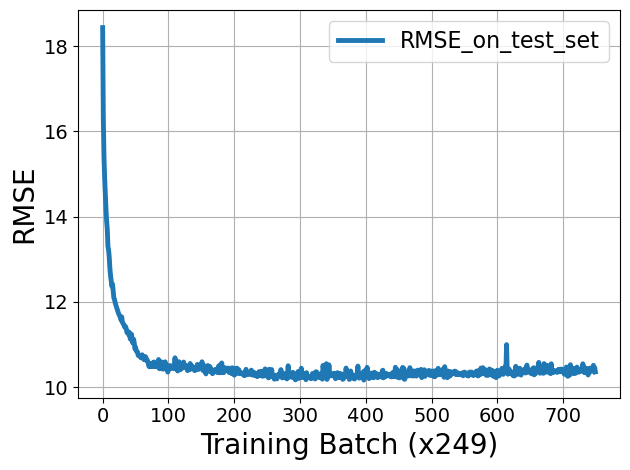

In [6]:
fig,ax = plt.subplots()
ax.plot(RMSE_list,label='RMSE_on_test_set',linewidth=3.5)
ax.set_xlabel('Training Batch (x249)',fontsize=20)
ax.set_ylabel('RMSE',fontsize=20)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('fig/ignnk_learning_curve_metr-la.pdf')

Draw spatial information of METR-LA kriging

/Users/haomei/opt/miniconda3/envs/easypredict/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/haomei/opt/miniconda3/envs/easypredict/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/haomei/opt/miniconda3/envs/easypredict/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/haomei/opt/miniconda3

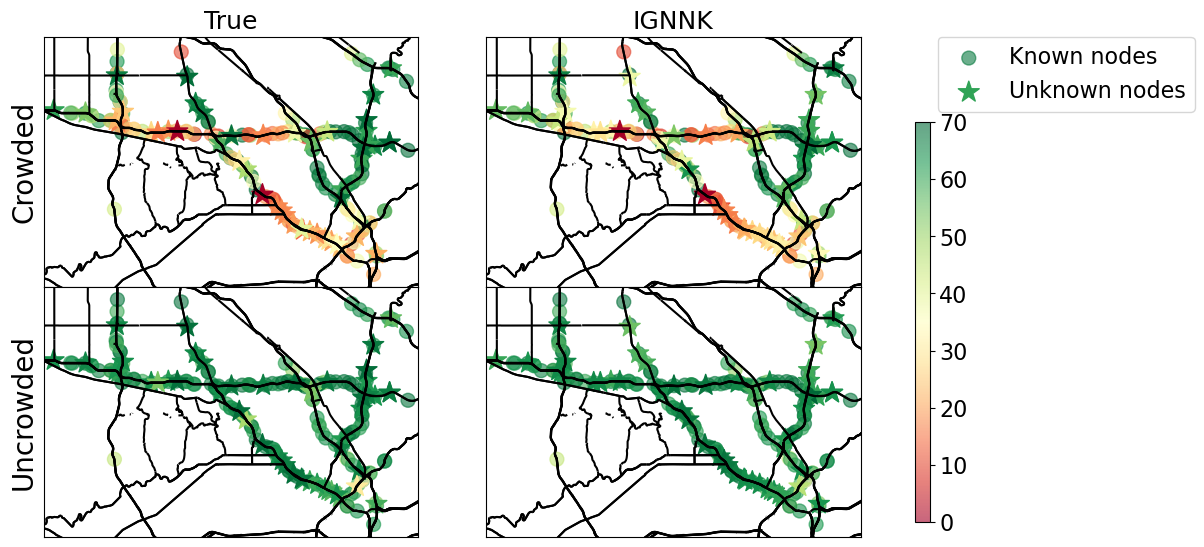

In [7]:
url_census='data/metr/Census_Road_2010_shapefile/Census_Road_2010.shp'
meta_locations = pd.read_csv('data/metr/graph_sensor_locations.csv')
map_metr=gp.read_file(url_census,encoding="utf-8")
fig,axes = plt.subplots(2,2,figsize = (10,5))
lng_div = 0.01
lat_div = 0.01
crowd = [127,160] #crowd and uncrowd, in the test time slice
ylbs = ['Crowded','Uncrowded']

for row in range(2):
    for col in range(2):
        ax = axes[row,col]
        map_metr.plot(ax=ax,color='black')
        ax.set_xlim((np.min(meta_locations['longitude'])-lng_div,np.max(meta_locations['longitude'])+lng_div))
        ax.set_ylim((np.min(meta_locations['latitude'])-lat_div,np.max(meta_locations['latitude'])+lat_div))
        ax.set_xticks([])
        ax.set_yticks([])
        if col == 0:
            cax=ax.scatter(meta_locations['longitude'][list(know_set)],meta_locations['latitude'][list(know_set)],s=100,cmap=plt.cm.RdYlGn, c = test_set[crowd[row],list(know_set)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = X.max()),alpha=0.6,label='Known nodes')
            cax2=ax.scatter(meta_locations['longitude'][list(unknow_set)],meta_locations['latitude'][list(unknow_set)],s=250,cmap=plt.cm.RdYlGn,c=test_set[crowd[row],list(unknow_set)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = X.max()),alpha=1,marker='*',label = 'Unknown nodes')
            ax.set_ylabel(ylbs[row],fontsize=20)
            if row == 0:
                ax.set_title('True',fontsize = 18)
        else:
            ax.scatter(meta_locations['longitude'][list(know_set)],meta_locations['latitude'][list(know_set)],s=100,cmap=plt.cm.RdYlGn, c = test_set[crowd[row],list(know_set)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = X.max()),alpha=0.6)
            ax.scatter(meta_locations['longitude'][list(unknow_set)],meta_locations['latitude'][list(unknow_set)],s=250,cmap=plt.cm.RdYlGn,c=metr_ignnk_res[crowd[row],list(unknow_set)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = X.max()),alpha=1,marker='*')
            if row == 0:
                ax.set_title('IGNNK',fontsize = 18)

fig.tight_layout()
fig.subplots_adjust(right = 0.9,hspace=0,wspace =0,bottom=0,top=1)
l = 0.92
b = 0.03
w = 0.015
h = 0.8
rect = [l,b,w,h] 
cbar_ax = fig.add_axes(rect) 
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=16)

plt.figlegend(handles=(cax,cax2),labels=('Known nodes','Unknown nodes'),bbox_to_anchor=(1.2, 1), loc=1, borderaxespad=0.,fontsize = 16 )
plt.savefig('fig/metr_ignnk_spatial_crowd{:}_uncrowd{:}.pdf'.format(crowd[0],crowd[1]))
plt.show()

Draw temporal information of METR-LA kriging

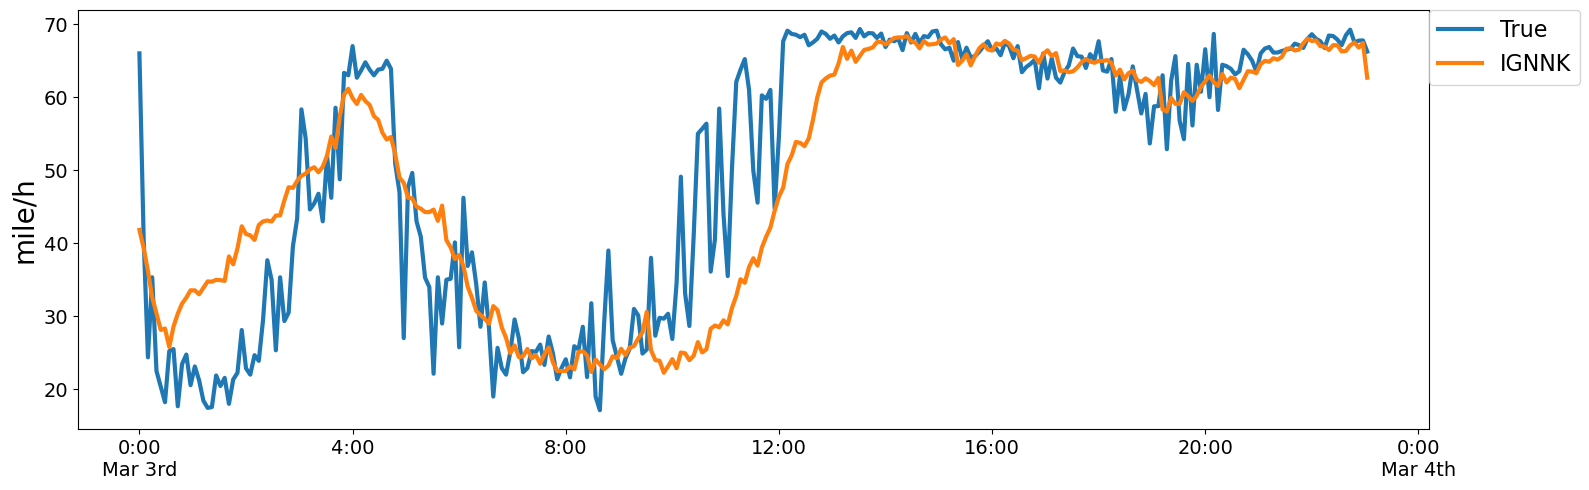

In [8]:
fig,ax = plt.subplots(figsize = (16,5))
s = int(6400-64 )
e = int(s + 24*60/5+1)
station = list(unknow_set)[24]
ax.plot(test_set[s:e,station],label='True',linewidth=3)
ax.plot(metr_ignnk_res[s:e,station],label='IGNNK',linewidth = 3)
ax.set_ylabel('mile/h',fontsize=20)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.set_xticks(range(0,350,50))
ax.set_xticklabels(['0:00\nMar 3rd','4:00','8:00','12:00','16:00','20:00','0:00\nMar 4th'])
ax.legend(bbox_to_anchor=(1, 1), loc=0, borderaxespad=0,fontsize=16)
plt.tight_layout()
plt.savefig('fig/metr_ignnk_temporal.pdf')
plt.show()